In [1]:
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import scipy.stats as st
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import preproc_dir, analysis_dir, database_dir
from storage import get_storage_functions
from hier_group import unpack_hier_names
import roi_utils

# Parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# ROI-based categorization
#============================================================================
face_cats = ('face', 'primate_face')


#============================================================================
# Time windows
#============================================================================
# for FSI
t_win = 150  # window width, starting from latency per-unit

# time windows for PSTHs
t_pre  = 375
t_post = 375
t_step =  10


#============================================================================
# statistics
#============================================================================
stat_tests_fsi = (('Fixation 1+', 'Fixation 0', 'two-sided'),)
stat_tests_fix = (('Face', 'Non', 'greater'),)
stat_tests_sacc = (
    (('Non', 'Non'), ('Non', 'Face'), 'less'),
    (('Face', 'Non'), ('Face', 'Face'), 'less'),
    (('Non', 'Face'), ('Face', 'Face'), 'two-sided'),
    (('Non', 'Non'), ('Face', 'Non'), 'two-sided'))
n_perm = 10000


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir
sdf_dir = preproc_dir
sdf_suffix = '-mwa_50'
rois_dir = '../db/ROIs'

rf_fit_path = database_dir + 'per_unit_rf.csv.gz'
latency_path = database_dir + 'per_unit_latency-fix_on.csv.gz'

output_dir = analysis_dir + 'face_specific'

In [3]:
# Parameters
sess_name = "Pa210201"
output_dir = "../test_results"


# Check parameters and whether already done

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

rasters_path = Path(proc_dir) / (sess_name + '-rasters.nwb')
print('Loading rasters from', rasters_path)
rasters_path = rasters_path.expanduser()
assert rasters_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

rf_fit_path = Path(rf_fit_path)
print('Loading Gaussian-fitted RF maps density function from', rf_fit_path)
rf_fit_path = rf_fit_path.expanduser()
assert rf_fit_path.is_file()

print('Using per-unit latency from', latency_path)
latency_path = Path(latency_path).expanduser()
assert latency_path.is_file()

print('Using ROIs in', rois_dir)
rois_dir = Path(rois_dir).expanduser()
assert rois_dir.is_dir()

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading rasters from ../test_data/Pa210201-rasters.nwb
Loading spike density function from ../test_data/Pa210201-sdf-mwa_50.h5
Loading Gaussian-fitted RF maps density function from ../db/per_unit_rf.csv.gz
Using per-unit latency from ../db/per_unit_latency-fix_on.csv.gz
Using ROIs in ../db/ROIs
Saving results to ../test_results/Pa210201.h5


In [5]:
analysis_name = 'face_specific'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [6]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
    im_root = f['stimulus/folder'][()].decode()  # scalar bytes -> str
    im_subds = f['stimulus/subdirectories'][()].astype(str)  # np array bytes -> str
im_dirs = set(f'{im_root}/{subd}'.strip('/') for subd in im_subds)

# check ROIs are available
print('Using ROIs in')
bydir_rois_dir = {}
for im_dir in set(im_dirs):
    rois_dir_ = rois_dir / im_dir.replace('/', '__')
    print(f'-\t{im_dir+":":<20}\t{rois_dir_}')

    # check for ROIs
    if rois_dir_.is_dir():
        # check for face ROIs
        with_face = False
        for n in face_cats:
            if (rois_dir_ / n).is_dir() or (rois_dir_ / f'{n}.csv').is_file():
                with_face = True
                break
        if with_face:
            bydir_rois_dir[im_dir] = rois_dir_
        else:
            print('\tNo face ROIs available for', im_dir)

    else:
        print('\tNo ROIs available for', im_dir)

assert len(bydir_rois_dir), f'No face ROIs available for any of the {len(set(im_dirs))} image dirs'

Using ROIs in
-	Stimuli:            	../db/ROIs/Stimuli


In [7]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [8]:
group = analysis_name + '/config/'
save_results(group+'face_cats', np.array(face_cats, dtype=bytes))
save_results(group+'sdf_suffix', sdf_suffix)
save_results(group+'random_seed', random_seed)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_win', t_win)
save_results(group+'t_pre',  t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/statistics/'
save_results(group+'tests_fix', str(stat_tests_fix))
save_results(group+'tests_sacc', str(stat_tests_sacc))
save_results(group+'test_kind', 'mannwhitneyu')

# Define RFs

In [9]:
with h5.File(sdf_path, 'r') as f:
    unit_names = f['sdf'].attrs['unit_names'].astype(str)
    if 'unit_names' in f:
        copy_group(f, 'unit_names', analysis_name+'/unit_names')

unit_names0 = unit_names.copy()
unit_names = unpack_hier_names(unit_names)
unit_names = unit_names[unit_names[:,0]=='Unit', 1]

In [10]:
unit_rf_df = pd.read_csv(rf_fit_path).set_index('Session')
assert sess_name in unit_rf_df.index, 'No unit has good RF fits'

unit_rf_df = unit_rf_df.loc[[sess_name]].set_index('Name')
assert not unit_rf_df.index.has_duplicates
unit_names = unit_rf_df.index.intersection(unit_names).values
print(f'{len(unit_names)} of {len(unit_names0)} ({(len(unit_names)/len(unit_names0))*100:.1f}%) units have fitted RFs')

unit_rf_df = unit_rf_df.loc[unit_names].reset_index()
assert len(unit_rf_df) == len(unit_names)
print('Num units using RF fit from each source:')
print('\t' + '\n\t'.join(str(unit_rf_df.groupby('Source').count()['x']).split('\n')[:-1]))

92 of 92 (100.0%) units have fitted RFs
Num units using RF fit from each source:
	Source
	Channel    13
	Default    39
	Unit       40


In [11]:
save_results(analysis_name+'/unit_names', unit_names.astype(bytes))
unit_rf_df.to_hdf(output_path, analysis_name+'/rf_per_unit', mode='a', format='table', complevel=9, complib='zlib')
unit_rf_df['Index'] = np.arange(len(unit_rf_df))

# Categorize fixations using ROIs

In [12]:
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')

with h5.File(proc_path, 'r') as f:
    fix_sel = f['fixation_selection/fixation_indices'][()]
    ppd = f['stimulus/pixels_per_degree'][()]
    im_size_px = f['stimulus/size_px'][()]    

In [13]:
df_ = fix_df.iloc[fix_sel].reset_index()

# select trials with define ROIs
tr_sel = set()
for itr, row in df_.groupby('Trial').first().iterrows():
    subd = row['Image subdir']
    d = f'{im_root}/{subd}'.strip('/')
    if d in bydir_rois_dir:
        tr_sel.add(itr)

# select fixations within selected trials
fix_subsel = df_['Trial'].isin(tr_sel).values
print(f'from {fix_subsel.size} fixations, selecting {fix_subsel.sum()} ({fix_subsel.mean()*100:.1f}%) in image folder(s) with face ROIs')
assert fix_subsel.any()
fix_sel = fix_sel[fix_subsel]

from 5979 fixations, selecting 5979 (100.0%) in image folder(s) with face ROIs


In [14]:
categories = np.unique(np.concatenate([
    roi_utils.tally_roi_cats(d)
    for d in bydir_rois_dir.values()]))
print('Defined ROI categories:', categories)

Defined ROI categories: ['face' 'face_metamer' 'occluded_face' 'other_face' 'pareidolia'
 'primate_face' 'primate_face_clutter' 'primate_face_clutter_inverted'
 'primate_face_metamer']


In [15]:
next_fix_sel = np.full_like(fix_sel, -1)
for ii, (itr, ifix) in enumerate(fix_df.index[fix_sel]):
    try:
        next_fix_sel[ii] = fix_df.index.get_loc((itr, ifix+1))
    except KeyError:
        pass
m = next_fix_sel != -1
print(f'{m.sum()} of {m.size} ({m.mean()*100:.1f}%) selected fixations have a next fixation')

4376 of 5979 (73.2%) selected fixations have a next fixation


In [16]:
cat_dfs = []
cls_dfs = []
next_cat_dfs = []

unit_groups = []

for igroup, ((rf_x, rf_y, rf_size), df_) in enumerate(tqdm(unit_rf_df.groupby(['x', 'y', 'r']))):
    unit_groups.append(df_['Index'].values)

    dilate_px = int(round(ppd.mean() * rf_size / 2))
    rf_xy_px = np.round(np.array([rf_x, rf_y]) * ppd).astype(int)

    cat_df = {k: [] for k in categories}
    cls_df = {k: [] for k in categories}
    next_cat_df = {k: [] for k in categories}

    for ii, (_, row) in enumerate(fix_df.iloc[fix_sel].iterrows()):
        imfn = row['Image filename']

        rel = row[['Relative X', 'Relative Y']].values.astype(float) + [rf_x, rf_y]
        rel_px = np.round(rel * ppd).astype(int)

        subd = row['Image subdir']
        d = f'{im_root}/{subd}'.strip('/')
        rois_dir = bydir_rois_dir[d]

        for cat in categories:
            is_cat, cls = roi_utils.is_on_roi(
                imfn, im_size_px, rel_px,
                cat, rois_dir, dilate_px)
            cat_df[cat].append(is_cat)
            cls_df[cat].append(cls)

        ifix_next = next_fix_sel[ii]
        if ifix_next == -1:
            for cat in categories:
                next_cat_df[cat].append(False)
        else:
            next_row = fix_df.iloc[ifix_next]
            next_rel = next_row[['Relative X', 'Relative Y']].values.astype(float) + [rf_x, rf_y]
            next_rel_px = np.round(next_rel * ppd).astype(int)
            for cat in categories:
                is_cat, cls = roi_utils.is_on_roi(
                    imfn, im_size_px, next_rel_px,
                    cat, rois_dir, dilate_px)
                next_cat_df[cat].append(is_cat)

    cat_df = pd.DataFrame(cat_df)
    cls_df = pd.DataFrame(cls_df)
    next_cat_df = pd.DataFrame(next_cat_df)
    cat_df['Fixation index'] = cls_df['Fixation index'] = next_cat_df['Fixation index'] = fix_sel
    cat_df['Group'] = cls_df['Group'] = next_cat_df['Group'] = igroup
    cat_dfs.append(cat_df)
    cls_dfs.append(cls_df)
    next_cat_dfs.append(next_cat_df)

cat_df = pd.concat(cat_dfs).set_index(['Group', 'Fixation index'])
cls_df = pd.concat(cls_dfs).set_index(['Group', 'Fixation index'])
next_cat_df = pd.concat(next_cat_dfs).set_index(['Group', 'Fixation index'])

# keep only categories that appear
categories = list(cat_df.columns[cat_df.any(axis=0)])
cat_df = cat_df[categories]
cls_df = cls_df[categories]
next_cat_df = next_cat_df[categories]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [16:35<00:00, 24.90s/it]

In [17]:
print('Overall fraction of fixations per category:')
cat_df.mean()

Overall fraction of fixations per category:


face            0.056101
face_metamer    0.018916
dtype: float64

In [18]:
print('Num fixations per cluster per category (0 is backgroud)')
for c in cls_df.columns:
    print(cls_df[c].value_counts().sort_index())
    print()

Num fixations per cluster per category (0 is backgroud)
face
0     61086
1    178074
Name: count, dtype: int64

face_metamer
0    179073
1     60087
Name: count, dtype: int64



In [19]:
face_cats = list(set(cat_df.columns) & set(face_cats))
fix_is_face = cat_df[face_cats].values.any(1)
fix_is_non = ~cat_df.values.any(1)
print(f'Fraction of face fixations: {fix_is_face.mean()*100:4.1f}%')
print(f'Fraction of nonface fixations: {fix_is_non.mean()*100:4.1f}%')

Fraction of face fixations:  5.6%
Fraction of nonface fixations: 92.5%


In [20]:
group = analysis_name + '/'
save_results(group+'fixation_selection', fix_sel)
for igroup, usel in enumerate(unit_groups):
    save_results(group+f'unit_groups/{igroup}', usel)
cat_df.reset_index().to_hdf(output_path, group+'categorization', mode='a', format='table', complevel=9, complib='zlib')
cls_df.reset_index().to_hdf(output_path, group+'cluster_id', mode='a', format='table', complevel=9, complib='zlib')

# Load neural data

In [21]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    all_unit_names = list(dset.attrs['unit_names'].astype(str))
    sel_ = np.array([all_unit_names.index(n) for n in unit_names])
    sdf = dset[()][:,sel_]

sdf.shape, sdf.dtype

((6234150, 92), dtype('float32'))

In [22]:
with h5.File(rasters_path, 'r') as f:
    all_unit_names = list(f['processing/ecephys/unit_names/unit_name'][()].astype(str))
    sel_ = np.array([all_unit_names.index(n) for n in unit_names])
    rasters = f['processing/ecephys/rasters/data'][()][:,sel_]

rasters.shape, rasters.dtype

((6234150, 92), dtype('uint8'))

# Get latency per unit

In [23]:
lat_df = pd.read_csv(latency_path).set_index('Session').loc[[sess_name]].set_index('Name')
m = pd.Series(unit_names).isin(lat_df.index)
assert m.all(), f'missing latency value for {(~m).sum()} of {m.size} units'
assert not lat_df.index.has_duplicates

lat_df = lat_df.loc[unit_names].reset_index()
assert len(lat_df) == len(unit_names)
lat_df['Latency'] = np.clip(lat_df['Latency'], 40, None)
print('Num units using RF fit from each source:')
print('\t' + '\n\t'.join(str(lat_df.groupby('Source').count()['Latency']).split('\n')[:-1]))

Num units using RF fit from each source:
	Source
	Array                 29
	Array, across sess    40
	Channel               11
	Unit                  12


In [24]:
lat_df.to_hdf(output_path, analysis_name+'/latency_per_unit', mode='a', format='table', complevel=9, complib='zlib')

# One-fixation analysis: FSI, PSTHs, Fix 0 vs Fix 1+
Excluding face → face saccades for fix 1+

In [25]:
rg = np.random.default_rng(random_seed)

def calculate_fsi(a, b):
    """ a, b shape (n_fix, n_neur) """
    # assert a.ndim == b.ndim == 2
    # assert a.shape[1] == b.shape[1]
    fsi = np.full(a.shape[1], np.nan, dtype=np.float32)
    a = a.mean(0)
    b = b.mean(0)
    denom = a + b
    m = denom != 0
    fsi[m] = (a[m] - b[m]) / denom[m]
    return fsi

def fsi_perm_test(val_dict, test, alts, n_permutation=n_perm, range_=range, rg=rg):
    valss = [
        np.concatenate([val_dict[t][k] for t in test[:2]], axis=0)
        for k in ('Face', 'Non')]
    splits = []
    for k in ('Face', 'Non'):
        i = len(val_dict[test[0]][k])
        splits.append((slice(None, i), slice(i, None)))

    h1 = -1 * np.diff([
        calculate_fsi(*(valss[j][splits[j][i]] for j in range(2)))
        for i in range(2)], axis=0)
    assert len(h1) == 1
    h1 = h1[0]

    h0s = np.empty_like(h1, shape=(n_permutation, *h1.shape))
    for i in range_(n_permutation):
        [rg.shuffle(v, axis=0) for v in valss]
        h0s[i] = np.diff([
            calculate_fsi(*(valss[j][splits[j][i]] for j in range(2)))
            for i in range(2)], axis=0)

    h1 = np.ma.masked_invalid(h1)
    h0s = np.ma.masked_invalid(h0s)
    pvalss = []
    for alternative in alts:
        if alternative == 'greater':
            pvals = h0s >= h1
        elif alternative == 'less':
            pvals = h0s <= h1
        else:
            pvals = np.abs(h0s) >= np.abs(h1)

        isvalid = np.broadcast_to(~pvals.mask, pvals.shape)
        pvals = pvals.mean(0).filled(np.nan)
        pvals_floor = 1/(isvalid.sum(0)+1)
        pvals = np.clip(pvals, pvals_floor, None)

        pvalss.append(pvals)

    return pvalss

In [26]:
n_neur = unit_names.size
ts = np.arange(-t_pre, t_post+t_step/10, t_step)

f01_fn_nfix = np.empty((2, 2, n_neur), dtype=int)
f01_fsi = np.full((2, n_neur), np.nan, dtype=np.float32)
f01_fs_pvals = np.full((len(stat_tests_fix), 2, n_neur), np.nan)
f0v1_fsi_pvals = np.full((len(stat_tests_fsi), n_neur), np.nan)
f01_fn_psths_mean_std = np.empty((2, 2, 2, ts.size, n_neur), dtype=sdf.dtype)
f01_psth_pvals = np.full((len(stat_tests_fix), 2, ts.size, n_neur), np.nan)

stat_tests_fsi_df = pd.DataFrame(
    data=stat_tests_fsi, columns=['Cond 0', 'Cond 1', 'Alt'])

f01s = fix_df.iloc[fix_sel].index.get_level_values(fix_df.index.names.index('Fixation'))
for igroup, usel in enumerate(unit_groups):
    cat_df_ = cat_df.loc[igroup, slice(None)]
    fix_is_non = ~cat_df_.values.any(1)
    fix_is_face = cat_df_[face_cats].values.any(1)

    next_cat_df_ = next_cat_df.loc[igroup, slice(None)]
    next_fix_is_face = next_cat_df_[face_cats].values.any(1)
    fix_is_face = fix_is_face & ~next_fix_is_face

    lat_df_ = lat_df.iloc[usel].copy()
    lat_df_['Index'] = np.arange(len(lat_df_))
    lat_groups_ = [(dt, df_['Index'].values) for dt, df_ in lat_df_.groupby('Latency')]

    byf01_fn_resps = {}

    for f01 in range(2):
        t_win_ = np.array([0, t_win])
        fn_resps = {}
        fn_psths = {}
        for icat, (cat, fix_is_cat) in enumerate((
                ('Non', fix_is_non),
                ('Face', fix_is_face))):
            if f01 == 0:
                m = f01s == 0 & fix_is_cat
            else:
                m = f01s > 0
            m &= fix_is_cat
            fix_sel_ = fix_sel[m]
            nfix = fix_sel_.size

            resps = np.empty((nfix, usel.size), dtype=np.float32)
            psths = np.empty((nfix, ts.size, usel.size), dtype=sdf.dtype)

            for i, t in enumerate(fix_df.iloc[fix_sel_]['Time'].values):
                for dt, usubsel in lat_groups_:
                    s = slice(*np.round(t+dt+t_win_).astype(int))
                    resps[i,usubsel] = rasters[s, usel[usubsel]].mean(0)

                ts_ = np.round(t+ts).astype(int)
                psths[i] = sdf[ts_][:, usel]

            fn_resps[cat] = resps
            fn_psths[cat] = psths
            f01_fn_nfix[f01, icat, usel] = nfix
            f01_fn_psths_mean_std[f01,icat,0,:,usel] = psths.mean(0).T
            f01_fn_psths_mean_std[f01,icat,1,:,usel] = psths.std(0).T

        byf01_fn_resps[('Fixation 0', 'Fixation 1+')[f01]] = fn_resps
        f01_fsi[f01, usel] = calculate_fsi(fn_resps['Face'], fn_resps['Non'])

        for it, test in enumerate(stat_tests_fix):
            alt = test[2] if len(test) > 2 else 'two-sided'
            x, y = (fn_resps[cond] for cond in test[:2])
            if x.size and y.size:
                f01_fs_pvals[it,f01,usel] = st.mannwhitneyu(
                    x=x, y=y, alternative=alt, axis=0).pvalue
            x, y = (fn_psths[cond] for cond in test[:2])
            if x.size and y.size:
                f01_psth_pvals[it,f01,:,usel] = st.mannwhitneyu(
                    x=x, y=y, alternative=alt, axis=0).pvalue.T

    for test, df_ in stat_tests_fsi_df.groupby(['Cond 0', 'Cond 1']):
        alts = list(df_['Alt'].values)
        pvalss = fsi_perm_test(byf01_fn_resps, test, alts)
        for it, pvals in zip(df_.index.values, pvalss):
            f0v1_fsi_pvals[it,usel] = pvals

del resps, psths, fn_resps, fn_psths

In [27]:
dims = np.array(('test', 'two_sample_test', 'fixation_type', 'category', 'statistic', 'time', 'unit'))
compr = dict(compression='gzip', compression_opts=9)
coords = {
    'test': np.array([str(v) for v in stat_tests_fix]),
    'two_sample_test': np.array([str(v) for v in stat_tests_fsi]),
    'fixation_type': np.array(('zeroth', 'non-zeroth')),
    'category': np.array(('Non', 'Face')),
    'statistic': np.array(('Non', 'Face')),
    'time': ts,
    'unit': unit_names}
group = analysis_name + '/by_fixation/'


attrs = {'t_win': t_win, 'n_permutations': n_perm}
data_vars = {
    'face_selectivity_index': (dims[[2,-1]], f01_fsi),
    'p-value': (dims[[0,2,-1]], f01_fs_pvals),
    'two-sample_p-value': (dims[[1,-1]], f0v1_fsi_pvals),
    'num_fixations': (dims[[2,3,-1]], f01_fn_nfix)}
dataset = xr.Dataset(data_vars, coords=coords, attrs=attrs)
encoding = {
    k: dict(chunksizes=v.shape, **compr) if v.size else {}
    for k, v in dataset.data_vars.items()}
dataset.to_netcdf(
    output_path, group=group+'face_selectivity',
    mode='a', engine='h5netcdf', encoding=encoding)


data_vars = {
    'data': (dims[2:], f01_fn_psths_mean_std),
    'p-value': (dims[[0,2,-2,-1]], f01_psth_pvals),
    'num_fixations': (dims[[2,3,-1]], f01_fn_nfix)}
dataset = xr.Dataset(data_vars, coords=coords)
dataset['data'].attrs.update({'unit': 'spikes/s'})
encoding = {
    k: dict(chunksizes=v.shape, **compr) if v.size else {}
    for k, v in dataset.data_vars.items()}
dataset.to_netcdf(
    output_path, group=group+'psth',
    mode='a', engine='h5netcdf', encoding=encoding)

# Across-saccade analysis: PSTHs

In [28]:
with h5.File(proc_path, 'r') as f:
    sacc_sel = f['saccade_selection/fixation_indices'][()]  # shape (2, n)
    lg_sacc_mask = f['saccade_selection/large/saccade_subset'][()]  # shape (n,) bool mask

# to avoid onset-transient, sub-select saccades that do not start_with fix 0
non_zeroth = 0 != fix_df.index.get_level_values(fix_df.index.names.index('Fixation'))[sacc_sel[0]]
print(f'from {sacc_sel.shape[1]} saccades, selecting:')
print(f'\t{non_zeroth.sum()} ({non_zeroth.mean()*100:.1f}%) to exclude zeroth fixations')

# select saccades within selected trials
df_ = fix_df.iloc[sacc_sel[0]].reset_index()
sacc_subsel = df_['Trial'].isin(tr_sel).values
df_ = fix_df.iloc[sacc_sel[1]].reset_index()
sacc_subsel &= df_['Trial'].isin(tr_sel).values
print(f'\t{sacc_subsel.sum()} ({sacc_subsel.mean()*100:.1f}%) in image folder(s) with face ROIs')

sacc_subsel &= non_zeroth
print(f'\t{sacc_subsel.sum()} ({sacc_subsel.mean()*100:.1f}%) by both two criteria1')
sacc_sel = sacc_sel[:,sacc_subsel]
lg_sacc_mask = lg_sacc_mask[sacc_subsel]

assert not(set(sacc_sel.ravel()) - set(fix_sel) )

from 4037 saccades, selecting:
	3348 (82.9%) to exclude zeroth fixations
	4037 (100.0%) in image folder(s) with face ROIs
	3348 (82.9%) by both two criteria1


In [29]:
# divide saccades into 2x2 categories
sacc_cat = np.full_like(sacc_sel, -1, dtype=int)
fix_is_face_ = cat_df[face_cats].groupby('Fixation index').any().any(axis=1)
fix_is_non_ = ~cat_df.any(axis=1).groupby('Fixation index').any()
for i in range(2):
    sacc_cat[i, fix_is_non_.loc[sacc_sel[i]]] = 0
    sacc_cat[i, fix_is_face_.loc[sacc_sel[i]]] = 1
m = (sacc_cat >= 0).all(0)
print(f'from {m.size} saccades ({lg_sacc_mask.sum()} large),', end=' ')
sacc_sel = sacc_sel[:,m]
lg_sacc_mask = lg_sacc_mask[m]
sacc_cat = sacc_cat[:,m]
print(f'selecting {m.sum()} ({lg_sacc_mask.sum()} large) between face and nonface')

from 3348 saccades (2022 large), selecting 3056 (1811 large) between face and nonface


In [30]:
# Equalize images across saccade selections:
#    further select those saccades occurring on
#    images that contained any condition involving face fixations
#    this makes sure non -> non saccades concern the same images involved in
#    (any of) the other 3 conditions. the criteria below consider both fixations
#    across a saccade, because if, say, only fix 2 is considered, a saccade such
#    as 3rd-category -> face would lead to the inclusion of an image that may not
#    be involved in any of the 2x2 conditions
imfns_sel = fix_df.iloc[sacc_sel[0, (sacc_cat>0).any(0) & lg_sacc_mask]]['Image filename'].unique()

print(f'from {sacc_sel.shape[1]} saccades ({lg_sacc_mask.sum()} large),', end=' ')
m = fix_df.iloc[sacc_sel[0]]['Image filename'].isin(imfns_sel)
sacc_sel = sacc_sel[:,m]
lg_sacc_mask = lg_sacc_mask[m]
sacc_cat = sacc_cat[:,m]
print(f'selecting {m.sum()} ({lg_sacc_mask.sum()} large) '
      f'involving {len(imfns_sel)} images with face saccades')

from 3056 saccades (1811 large), selecting 1710 (1145 large) involving 270 images with face saccades


In [31]:
byscond_scat_psth_mean_std = {
    # fix 1 cat, fix 2 cat, mean/std, time, unit
    k: np.full((2, 2, 2, ts.size, n_neur), np.nan, dtype=sdf.dtype)
    for k in ('all', 'large')}
byscond_sacc_cat_dfs = {k: [] for k in ('all', 'large')}
byscond_pvals = {
    k: np.full((len(stat_tests_sacc), ts.size, n_neur), np.nan)
    for k in ('all', 'large')}

for igroup, usel in enumerate(tqdm(unit_groups)):
    # divide saccades into 2x2 categories
    sacc_cat_ = np.full_like(sacc_sel, -1, dtype=int)
    fix_is_face_ = cat_df.loc[(igroup,slice(None)),][face_cats].any(axis=1)
    fix_is_non_ = ~cat_df.loc[(igroup,slice(None)),].any(axis=1)
    for i in range(2):
        sacc_cat_[i, fix_is_non_.loc[(igroup,sacc_sel[i]),]] = 0
        sacc_cat_[i, fix_is_face_.loc[(igroup,sacc_sel[i]),]] = 1
    m = (sacc_cat_ >= 0).all(0)
    sacc_sel_ = sacc_sel[:,m]
    lg_sacc_mask_ = lg_sacc_mask[m]
    sacc_cat_ = sacc_cat_[:,m]

    sacc_cat_df = pd.DataFrame(np.array(['Non', 'Face'])[sacc_cat_.T], columns=['Fix 1 cat', 'Fix 2 cat'])
    sacc_cat_df[['Fix 1 index', 'Fix 2 index']] = sacc_sel_.T

    byscat_psths = {}
    for scond, sacc_cat_df_ in (
            ('all', sacc_cat_df),
            ('large', sacc_cat_df[lg_sacc_mask_])):
        psth_mean_std = byscond_scat_psth_mean_std[scond]

        for scat, df_ in sacc_cat_df_.groupby(['Fix 1 cat', 'Fix 2 cat']):
            i1, i2 = map(['Non', 'Face'].index, scat)
            n_sacc = len(df_)
            psths = np.empty((n_sacc, ts.size, usel.size), dtype=sdf.dtype)
            for i, t in enumerate(fix_df.iloc[df_['Fix 2 index'].values]['Time'].values):
                ts_ = np.round(t+ts).astype(int)
                psths[i] = sdf[ts_][:, usel]
            byscat_psths[scat] = psths
            psth_mean_std[i1,i2,0,:,usel] = psths.mean(0).T  # transpose due to
            psth_mean_std[i1,i2,1,:,usel] = psths.std(0).T   # numpy indexing weirdness

        sacc_cat_df_ = sacc_cat_df_.copy()
        sacc_cat_df_['Group'] = igroup
        byscond_sacc_cat_dfs[scond].append(sacc_cat_df_)

        for it, test in enumerate(stat_tests_sacc):
            c0, c1 = test[:2]
            alt = test[2] if len(test) > 2 else 'two-sided'
            if c0 in byscat_psths and c1 in byscat_psths:
                byscond_pvals[scond][it,:,usel] = st.mannwhitneyu(
                    x=byscat_psths[c0],
                    y=byscat_psths[c1],
                    alternative=alt,
                    axis=0
                ).pvalue.T  # transpose due to numpy indexing weirdness

del sdf

for k, v in byscond_sacc_cat_dfs.items():
    byscond_sacc_cat_dfs[k] = pd.concat(v)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:26<00:00,  2.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:26<00:00,  1.50it/s]

In [32]:
dims = np.array(('test', 'fix1_category', 'fix2_category', 'statistic', 'time', 'unit'))
coords = {
    'test': np.array([str(v) for v in stat_tests_sacc]),
    'fix1_category': np.array(('Non', 'Face')),
    'fix2_category': np.array(('Non', 'Face')),
    'statistic': np.array(['mean', 'std']),
    'time': ts,
    'unit': unit_names}
compr = dict(compression='gzip', compression_opts=9)

for scond, psth_mean_std in byscond_scat_psth_mean_std.items():
    group = analysis_name + f'/by_saccade/by_saccade_size/{scond}/'
    pvals = byscond_pvals[scond]
    data_vars = {
        'data': (dims[1:], psth_mean_std),
        'p-value': (dims[[0,-2,-1]], pvals)}
    dataset = xr.Dataset(data_vars, coords=coords)
    dataset['data'].attrs.update({'unit': 'spikes/s'})

    encoding = {
        k: dict(chunksizes=v.shape, **compr) if v.size else {}
        for k, v in dataset.data_vars.items()}
    dataset.to_netcdf(
        output_path, group=group+'psth',
        mode='a', engine='h5netcdf', encoding=encoding)

    kwargs = dict(mode='a', format='table', complevel=9, complib='zlib')
    byscond_sacc_cat_dfs[scond]\
        .to_hdf(output_path, group+'saccade_categorization', **kwargs)
    byscond_sacc_cat_dfs[scond].groupby(['Group', 'Fix 1 cat', 'Fix 2 cat'])\
        .count()['Fix 2 index'].rename('Count').reset_index()\
        .to_hdf(output_path, group+'num_saccades', **kwargs)

    if scond == 'large':
        save_results(group+'saccade_subset', lg_sacc_mask)

# Wrap up

In [33]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [34]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-18T14:13:07.447574-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
xarray: 2023.4.2
h5py  : 3.8.0
pandas: 2.0.1
scipy : 1.10.1
numpy : 1.24.3



# Basic visualization of results

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

### FSI for fix 0 and fix 1+

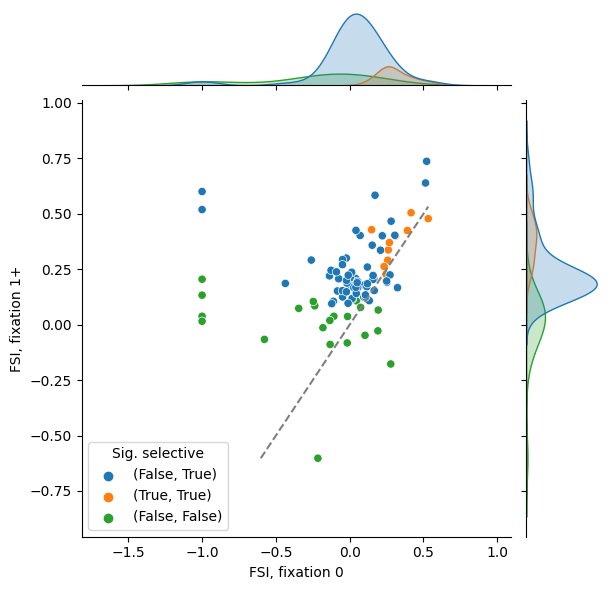

In [36]:
if f01_fsi.size and np.isfinite(f01_fsi).any(1).all(0):
    x = 'FSI, fixation 0'
    y = 'FSI, fixation 1+'
    h = 'Sig. selective'
    data = pd.DataFrame(data={x: f01_fsi[0], y: f01_fsi[1], h: list(map(tuple, (f01_fs_pvals[0]<0.01).T))})
    jg = sns.jointplot(data=data, x=x, y=y, hue=h)
    b = np.ma.masked_invalid(f01_fsi)
    b = [b.min(1).max(0), b.max(1).min(0)]
    jg.ax_joint.plot(b, b, color='gray', ls='--')

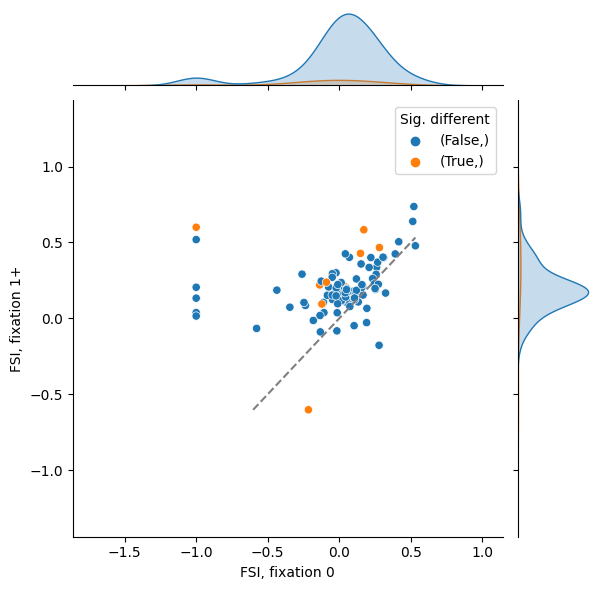

In [37]:
if f01_fsi.size:
    b = np.ma.masked_invalid(f01_fsi)
    m = ~b.mask.any(0)
    if m.any():
        b = b[:,m]
        x = 'FSI, fixation 0'
        y = 'FSI, fixation 1+'
        h = 'Sig. different'
        data = pd.DataFrame(data={x: f01_fsi[0], y: f01_fsi[1], h: list(map(tuple, (f0v1_fsi_pvals<0.01).T))})
        data = data[m]
        jg = sns.jointplot(data=data, x=x, y=y, hue=h)
        b = [b.min(1).max(0), b.max(1).min(0)]
        jg.ax_joint.plot(b, b, color='gray', ls='--');

### Face vs. non-face PSTHs for fix 0 and fix 1+

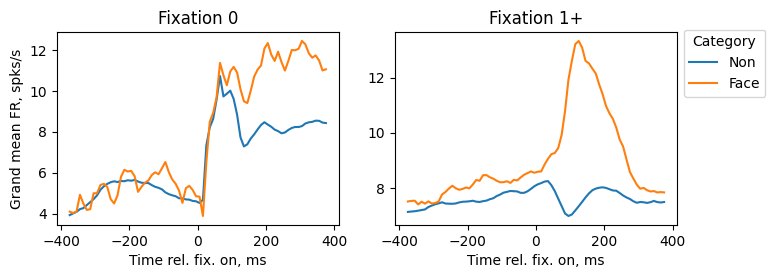

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(8,2.5))
for f01, ax in enumerate(axs):
    for icat, cat in enumerate(('Non', 'Face')):
        r = f01_fn_psths_mean_std[f01, icat, 0].mean(1)
        ax.plot(ts, r, label=cat)
    ax.set_title('Fixation ' + ('0', '1+')[f01])
    ax.set_xlabel('Time rel. fix. on, ms')
ax.legend(title='Category', loc='upper left', bbox_to_anchor=(1,1.05))
axs[0].set_ylabel('Grand mean FR, spks/s');

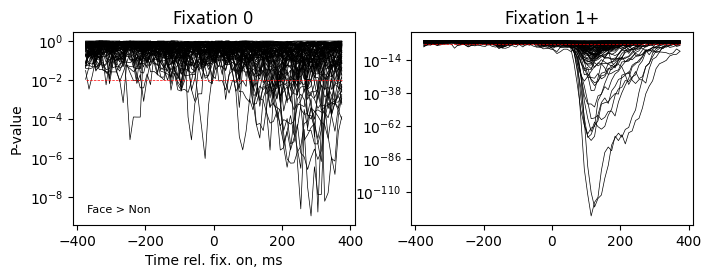

In [39]:
n = len(stat_tests_fix)
fig, axs = plt.subplots(n, 2, figsize=(8,2.5*n), squeeze=False)
for it, test in enumerate(stat_tests_fix):
    axs_ = axs[it]
    for f01, ax in enumerate(axs_):
        vs = f01_psth_pvals[0][f01]
        ax.plot(ts, vs, c='k', lw=0.5)
        ax.set_yscale('log')
        ax.hlines(.01, ts.min(), ts.max(), ls='--', lw=0.5, color='r')
        ax.set_title('Fixation ' + ('0', '1+')[f01])
    ax = axs_[0]
    ax.text(.05, .05, f'{test[0]} {dict(less="<",greater=">").get(test[2],"!=")} {test[1]}',
            ha='left', va='bottom', transform=ax.transAxes, fontsize=8)
    ax.set_xlabel('Time rel. fix. on, ms')
    ax.set_ylabel('P-value');

### Two-category PSTHs across saccades

/tmp/ipykernel_3596302/171259595.py:6: RuntimeWarning: Mean of empty slice
  r = np.nanmean(scat_psth_mean_std[icat1, icat2, 0], axis=1)


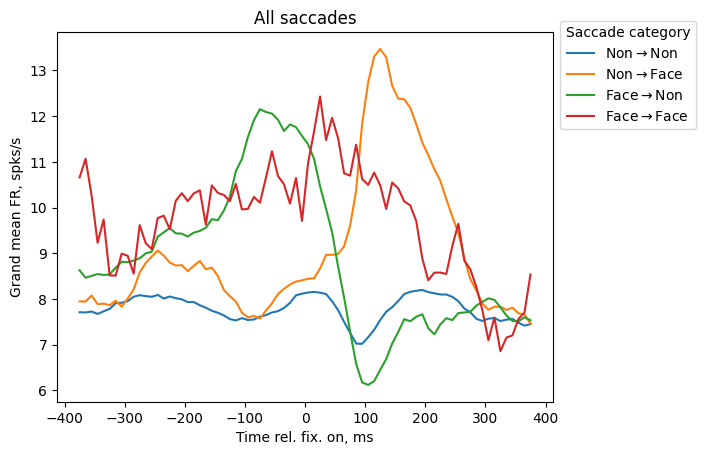

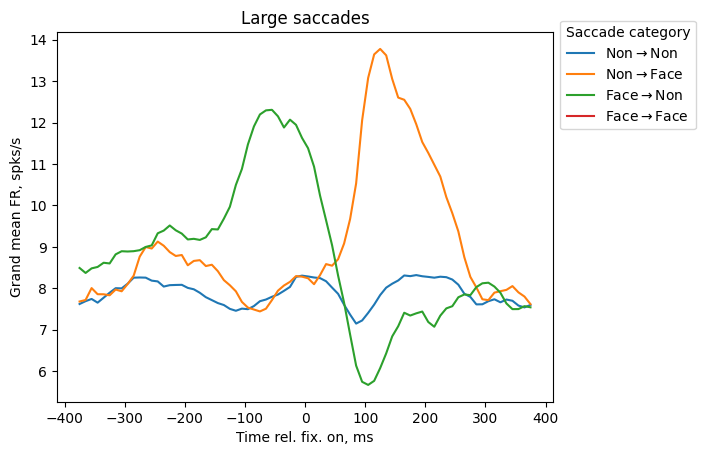

In [40]:
for scond, scat_psth_mean_std in byscond_scat_psth_mean_std.items():
    if not scat_psth_mean_std.size: continue
    plt.figure()
    for icat1, cat1 in enumerate(('Non', 'Face')):
        for icat2, cat2 in enumerate(('Non', 'Face')):
            r = np.nanmean(scat_psth_mean_std[icat1, icat2, 0], axis=1)
            plt.plot(ts, r, label=cat1+r'$\rightarrow$'+cat2)
    plt.xlabel('Time rel. fix. on, ms')
    plt.ylabel('Grand mean FR, spks/s')
    plt.legend(title='Saccade category', loc='upper left', bbox_to_anchor=(1,1.05))
    plt.title(scond.capitalize() + ' saccades')

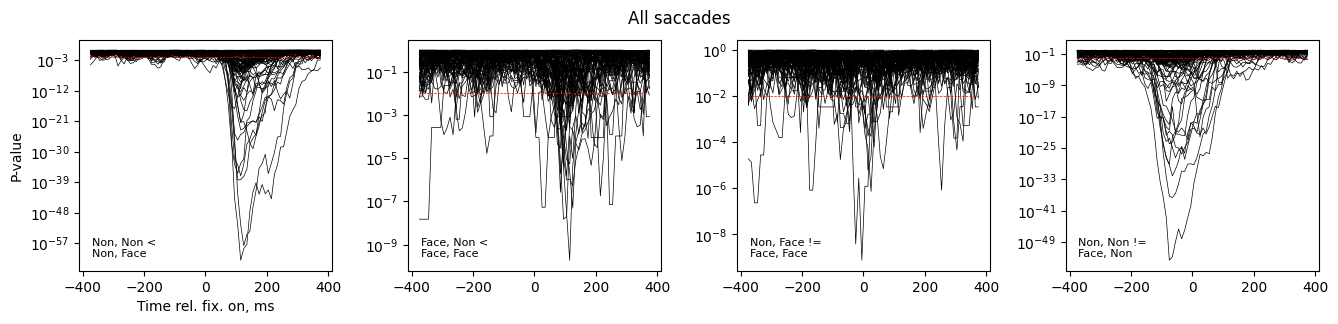

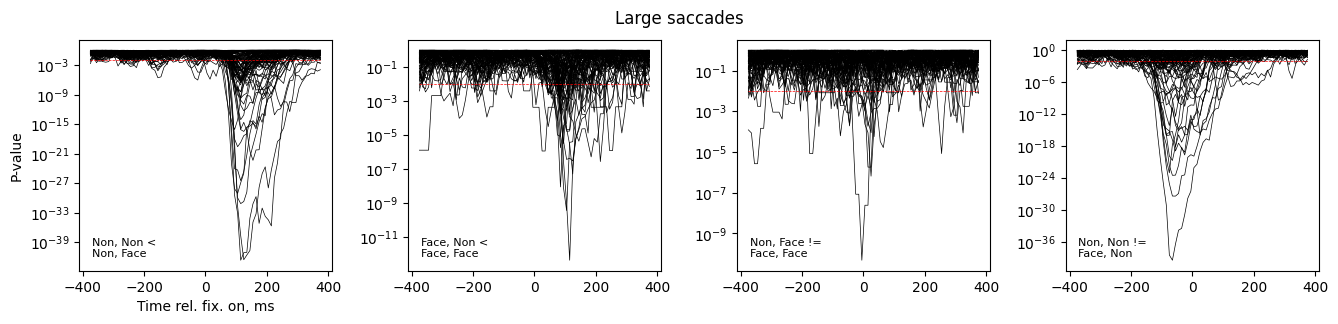

In [41]:
for scond, pvals in byscond_pvals.items():
    if not pvals.size: continue
    n = len(pvals)
    fig, axs = plt.subplots(1, n, figsize=(4*n,3), squeeze=False)
    plt.subplots_adjust(wspace=0.3)
    axs = axs.ravel()
    f = lambda x: x if isinstance(x, str) else ', '.join(map(str, x))
    for i, ax in enumerate(axs):
        vs = pvals[i]
        ax.plot(ts, vs, c='k', lw=0.5);
        ax.set_yscale('log')
        ax.hlines(.01, ts.min(), ts.max(), ls='--', lw=0.5, color='r')
        test = stat_tests_sacc[i]
        if len(test) < 3:
            test = test + ('two-sided',)
        ax.text(.05, .05, f'{f(test[0])} {dict(less="<",greater=">").get(test[2],"!=")}\n{f(test[1])}',
                ha='left', va='bottom', transform=ax.transAxes, fontsize=8)
    fig.suptitle(scond.capitalize() + ' saccades')
    axs[0].set_xlabel('Time rel. fix. on, ms')
    axs[0].set_ylabel('P-value')